In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('dataset/boulder_results.csv')

In [3]:
df.head()

,Competition Title,Competition Date,FIRST,LAST,Nation,StartNr,Rank,Qualification,Qualification 1,Qualification 2,Semifinal,Final,Category
0,European Youth Championships (B) - Brixen (ITA...,20 - 22 September 2019,Naile,MEIGNAN,FRA,15.0,1,6T7z99,NaN,NaN,3T4z55,3T4z89,boulder
1,European Youth Championships (B) - Brixen (ITA...,20 - 22 September 2019,Miriam,FOGU,ITA,27.0,2,4T8z814,NaN,NaN,3T4z55,2T4z27,boulder
2,European Youth Championships (B) - Brixen (ITA...,20 - 22 September 2019,Vanda,MICHALKOVA,SVK,48.0,3,6T7z89,NaN,NaN,3T3z43,2T3z23,boulder
3,European Youth Championships (B) - Brixen (ITA...,20 - 22 September 2019,Lola,SAUTIER,FRA,17.0,4,4T6z69,NaN,NaN,2T3z89,1T3z38,boulder
4,European Youth Championships (B) - Brixen (ITA...,20 - 22 September 2019,Polina,KULAGINA,RUS,39.0,5,4T6z611,NaN,NaN,3T4z76,1T3z47,boulder


# Project Goal: Make a model to predict how good a player should perform to pass the Qualification

## How to evaluate the score
Bouldering is scored using a combination of tops and zones to determine rank. Athletes each get four minutes to reach the top of four boulders (three in the final), with the number of attempts influencing their final score. The aim is to top the boulder in as few attempts as possible.

Results are in the format Tz__. T corresponds to top, which means the climber reached the top hold and finished the problem. z corresponds to zone, which means the climber reached the zone hold and partially finished the problem. The numbers before each correspond to how many tops or zones were reached, and numbers after signify how many attempts were taken.

Example:
2T4z58 means that the climber had 2 tops, 4 zones, and took 5 total attempts to get the tops, and 8 total attempts to reach the zones.

Qualification: Sometimes there are multiple groups for qualifications, and when that is the case the results will be split to indicate which qualification group the climber was in.

## Plan ahead
#### Data Acquisition
* Use a dataset uploaded on Kaggle. (Source: IFSC Sport Climbing Competition Results)

#### Data Cleaning
* Narrow down to adult competition only.
* Merge Qualification, Qual1, and Qual2 columns together for the reason mentioned above.
* Re-frame the string score data to numeric variables and check the correlation to the passing Qual.

#### Exploratory Data Analysis
* Check correlation between features and qualification result

#### Feature Engineering

#### Train / Test models
* Perform various classification methods: Logistic Regression, Tree-based mehtod, and Support Vector Classifier.

#### Evalutation of the model
* Consider accuracy and f1 score: Generally good score to evaluate the model.

## Data Cleaning

In [4]:
# Merge Qualification scores in one column
# print the number of null values and see if it decreases to 0
print(df['Qualification'].isnull().sum())
df['Qualification'].fillna(df['Qualification 1'], inplace=True)
print(df['Qualification'].isnull().sum())
df['Qualification'].fillna(df['Qualification 2'], inplace=True)
print(df['Qualification'].isnull().sum())

4309
2155
0


In [5]:
# Remove Qual 1 Qual 2 Columns
if df['Qualification'].isnull().sum()==0:
    df = df.drop(['Qualification 1','Qualification 2'], axis=1)

In [6]:
# Get rid of the Youth competition: 3197 entries left
df = df[~df['Competition Title'].str.contains('Youth')]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3197 entries, 282 to 6468
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Competition Title  3197 non-null   object 
 1   Competition Date   3197 non-null   object 
 2   FIRST              3197 non-null   object 
 3   LAST               3197 non-null   object 
 4   Nation             3197 non-null   object 
 5   StartNr            3197 non-null   float64
 6   Rank               3197 non-null   int64  
 7   Qualification      3197 non-null   object 
 8   Semifinal          800 non-null    object 
 9   Final              260 non-null    object 
 10  Category           3197 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 299.7+ KB


In [7]:
df['Category'].unique()

array(['ldering'], dtype=object)

In [8]:
df.drop('Category', axis=1, inplace=True)

In [9]:
df.head()

,Competition Title,Competition Date,FIRST,LAST,Nation,StartNr,Rank,Qualification,Semifinal,Final
282,European Championship (B) - Zakopane (POL) 2019,5 - 7 September 2019,Urska,REPUSIC,SLO,63.0,1,3T4z68,3T4z67,3T4z45
283,European Championship (B) - Zakopane (POL) 2019,5 - 7 September 2019,Vita,LUKAN,SLO,61.0,2,5T5z118,3T4z57,3T4z68
284,European Championship (B) - Zakopane (POL) 2019,5 - 7 September 2019,Irina,KUZMENKO,RUS,68.0,3,5T5z1513,3T4z510,3T4z817
285,European Championship (B) - Zakopane (POL) 2019,5 - 7 September 2019,Alma,BESTVATER,GER,67.0,4,4T4z84,3T4z46,3T3z33
286,European Championship (B) - Zakopane (POL) 2019,5 - 7 September 2019,Yael,TAUB,ISR,90.0,5,2T5z410,3T4z56,2T3z46


## Part 1: Convert string scores to numerical values
* Quantify the score from string to integers (# of tops, # of zones, # of top attempts, # of zone attempts)
* Make another columns to check if the player pass the Qual. If the player has semifinal score, consider the one passed the qualification.

In [10]:
def score(row, rnd): # rnd: string 'Qualification', 'Semifinal', Final
    temp = row[rnd].split('T')
    top = int(temp[0])
    temp = temp[1].split('z')
    zone = int(temp[0])
    
    # t_attempt >= top
    # z_attempt >= zone
    t_attempt = temp[1][0]  # Initial condition: first number after "z"
    i=1
    while int(t_attempt)<top:
        t_attempt=t_attempt+temp[1][i]
        i+=1
    
    z_attempt=temp[1][len(t_attempt):]
    if len(z_attempt)>2: # Attempts more than 100 is physically impossible. (you only have 4 mins)
        t_attempt=t_attempt+temp[1][len(t_attempt)]
        
    z_attempt = temp[1][len(t_attempt):]
    
    
    t_attempt=int(t_attempt)
    z_attempt=int(z_attempt)
    
    return [top, zone, t_attempt, z_attempt]

In [11]:
columns_to_add = ['top', 'zone', 'top attempts', 'zone attempts']
for idx, col in enumerate(columns_to_add):
    df[col] = df.apply(lambda row,rnd='Qualification': score(row,rnd)[idx], axis=1)

# Having Semifinal score -> Passed Qualification!

df['Pass Qual']=df['Semifinal'].notnull()
df['Pass Qual']=df['Pass Qual'].map({True:1, False:0})
df.head()

,Competition Title,Competition Date,FIRST,LAST,Nation,StartNr,Rank,Qualification,Semifinal,Final,top,zone,top attempts,zone attempts,Pass Qual
282,European Championship (B) - Zakopane (POL) 2019,5 - 7 September 2019,Urska,REPUSIC,SLO,63.0,1,3T4z68,3T4z67,3T4z45,3,4,6,8,1
283,European Championship (B) - Zakopane (POL) 2019,5 - 7 September 2019,Vita,LUKAN,SLO,61.0,2,5T5z118,3T4z57,3T4z68,5,5,11,8,1
284,European Championship (B) - Zakopane (POL) 2019,5 - 7 September 2019,Irina,KUZMENKO,RUS,68.0,3,5T5z1513,3T4z510,3T4z817,5,5,15,13,1
285,European Championship (B) - Zakopane (POL) 2019,5 - 7 September 2019,Alma,BESTVATER,GER,67.0,4,4T4z84,3T4z46,3T3z33,4,4,8,4,1
286,European Championship (B) - Zakopane (POL) 2019,5 - 7 September 2019,Yael,TAUB,ISR,90.0,5,2T5z410,3T4z56,2T3z46,2,5,4,10,1


#### Check if the scores are correctly generated
Attempts should be >= top or zone!

In [12]:
len(df[df['zone attempts']<df['zone']])

0

In [13]:
len(df[df['top attempts']<df['top']])

0

Both are zero. The scores are nicely converted.

## Part 2: Exploratory Data Analytics
#### Check list
* Passing rate (Pass Qual/total)
* Correlation to qualification result
* Distribution of each feature
* Presence of outliers: Deal with it at feature engineering step

#### Features
* Top score
* Zone score
* Top attempts
* Zone attempts

### 2.1. Passing Rate
About 25% of players pass the qualification

In [14]:
df_qual = df[['top','zone','top attempts','zone attempts','Pass Qual']]

In [15]:
df_qual.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3197 entries, 282 to 6468
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   top            3197 non-null   int64
 1   zone           3197 non-null   int64
 2   top attempts   3197 non-null   int64
 3   zone attempts  3197 non-null   int64
 4   Pass Qual      3197 non-null   int64
dtypes: int64(5)
memory usage: 149.9 KB


3200 Entries, No missing data

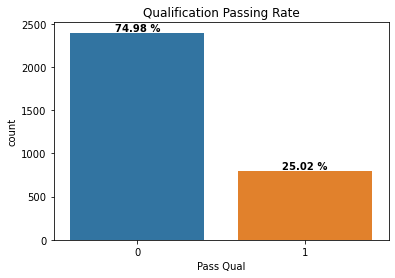

In [16]:
sns.countplot(x='Pass Qual', data=df_qual)
plt.title("Qualification Passing Rate")
for i in [0,1]:
    rate = 100 * df_qual['Pass Qual'].value_counts()[i]/len(df_qual)
    plt.text(i,df_qual['Pass Qual'].value_counts()[i],f"{rate:.2f} %",
             va='bottom', ha='center', weight='bold');

### Part 2.2. Correlations: all features to qual result
* Top > Zone > Top attempts >> Zone attempts: as expected

In [17]:
df_qual.corr()['Pass Qual'].sort_values().iloc[:-1]

zone attempts    0.155779
top attempts     0.474940
zone             0.523052
top              0.657668
Name: Pass Qual, dtype: float64

<AxesSubplot:>

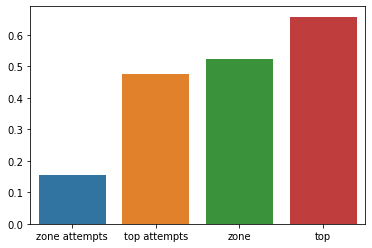

In [18]:
sns.barplot(x=df_qual.corr()['Pass Qual'].sort_values().iloc[:-1].index, y=df_qual.corr()['Pass Qual'].sort_values().iloc[:-1].values)

<AxesSubplot:>

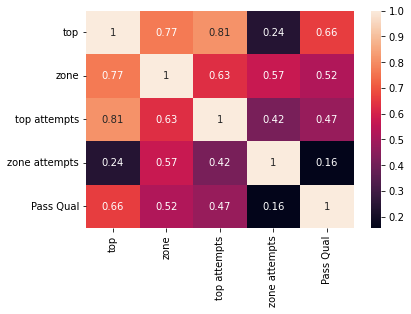

In [19]:
sns.heatmap(data=df_qual.corr(),annot=True)

### Part 2.3. Top score distribution and outliers
* High top scores lead to passing qual and lower top score lead to failing qual (positively correlated)
* Overall distribution has no outliers
* Outliers in passing qual: Some lucky players (62) passed qualification with 0 or 1 top scores

<AxesSubplot:xlabel='top', ylabel='count'>

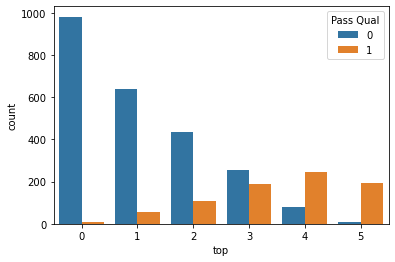

In [20]:
sns.countplot(x='top', data=df_qual, hue='Pass Qual')

In [21]:
def box_plots(df, feature):
    """
    Generates two box plots:
    1. Distribution of the feature
    2. Distribution of the feature grouped by Qualification result
    
    Print the number of Outliers:
    """
    iqr = df[feature].describe()["75%"] - df[feature].describe()["25%"]
    lower_lim = df[feature].describe()["25%"] - 1.5*iqr
    upper_lim = df[feature].describe()["75%"] + 1.5*iqr
    
    plt.figure()
    sns.boxplot(y=feature, data=df)
    plt.title(f'Overall {feature} Distribution')
    print(f'Upper Outliers: {len(df[df[feature]>upper_lim])}')
    print(f'Lower Outliers: {len(df[df[feature]<lower_lim])}')
    
    plt.figure()
    sns.boxplot(x='Pass Qual', y='top', data=df)
    plt.title(f'Grouped {feature} Distribution')

Upper Outliers: 0
Lower Outliers: 0


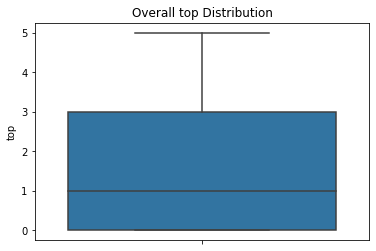

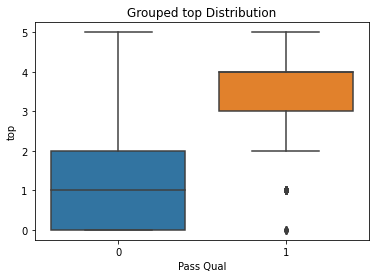

In [22]:
box_plots(df_qual, 'top')

In [23]:
len(df_qual[(df_qual['Pass Qual']==1)&(df_qual['top']<2)])

62

### Part 2.4. Top Attempts Distribution and Outliers
* Low top attempts -> Failing Qual
* Normally distributed for those who pass the qual
* 16 outliers

<AxesSubplot:xlabel='top attempts', ylabel='count'>

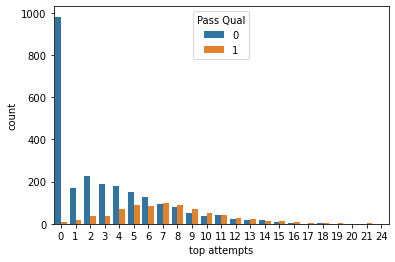

In [24]:
sns.countplot(x='top attempts', hue='Pass Qual', data=df_qual)

Upper Outliers: 16
Lower Outliers: 0


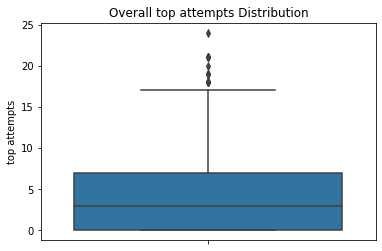

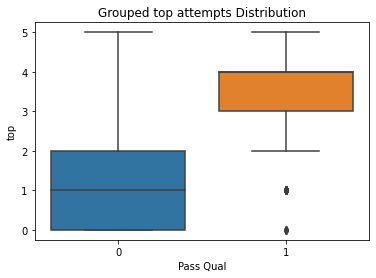

In [25]:
box_plots(df_qual,'top attempts')

### 2.5. Zone Distribution and Outliers
* Normally distributed for failing qual
* Positively correlated with passing qual
* No outlier detected

<AxesSubplot:xlabel='zone', ylabel='count'>

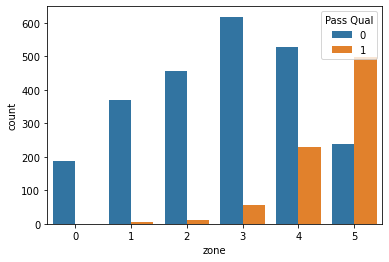

In [26]:
sns.countplot(x='zone', data=df_qual, hue='Pass Qual')

Upper Outliers: 0
Lower Outliers: 0


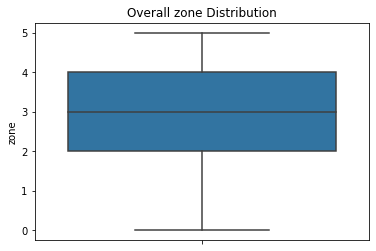

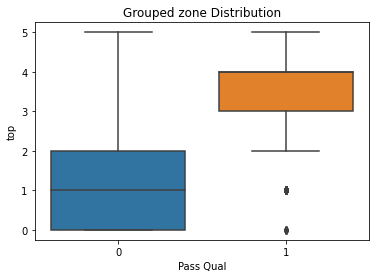

In [27]:
box_plots(df_qual, 'zone')

### 2.6. Zone attempts Distribution and Outliers
* Similarly distributed for both categories
* 52 Outliers detected

<AxesSubplot:xlabel='zone attempts', ylabel='count'>

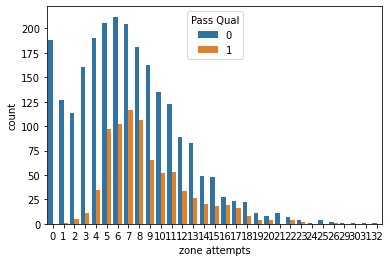

In [28]:
sns.countplot(x='zone attempts', data=df_qual, hue='Pass Qual')

Upper Outliers: 52
Lower Outliers: 0


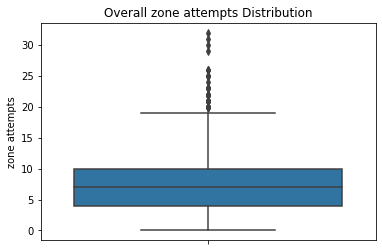

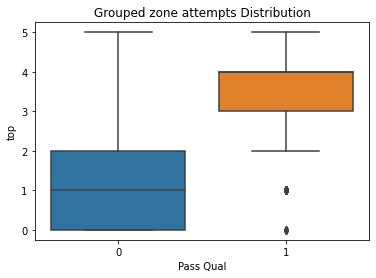

In [29]:
box_plots(df_qual, 'zone attempts')

## EDA Conclusion
* Outliers from passing qual consistently detected: There are some players who passed qualification with 0 and 1 top scores.
* Overall features are positively correlated with passing qualification.

## Part 3. Feature Engineering

* Remove those who passed qualification with 0 and 1 top scores
* Remove outliers detected from EDA
* Other features to consider: top attempts - top and zone attempts - zone might also be relevant. Check this possibility.

### Part 3.1. Remove Qualifiers with 0 and 1 top scores

In [30]:
df_qual = df_qual[df_qual['top']>1]

Upper Outliers: 0
Lower Outliers: 0


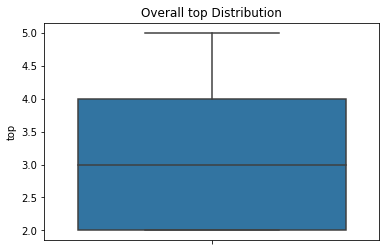

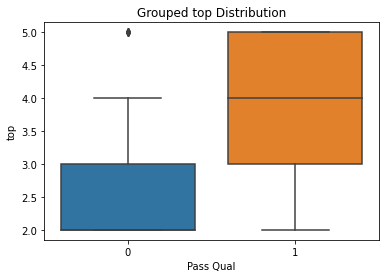

In [31]:
box_plots(df_qual,'top')

### Part 3.2. Remove Outliers from box plots
* Make a new dataframe: df_engineered
* Avoid affecting other feature's statistics

In [32]:
df_engineered = df_qual.copy()

In [33]:
for col in df_qual.columns[:-1]:
    iqr = df_qual[col].describe()["75%"] - df_qual[col].describe()["25%"]
    lower_lim = df_qual[col].describe()["25%"] - 1.5*iqr
    upper_lim = df_qual[col].describe()["75%"] + 1.5*iqr
    
    df_engineered=df_qual[(df_qual[col]<upper_lim)&(df_qual[col]>lower_lim)]
    
df_engineered = df_engineered.dropna(axis=0)

In [34]:
len(df_engineered)/len(df_qual)    # Dropped about 2% 

0.9828382838283828

In [35]:
df_engineered.head()

,top,zone,top attempts,zone attempts,Pass Qual
282,3,4,6,8,1
283,5,5,11,8,1
284,5,5,15,13,1
285,4,4,8,4,1
286,2,5,4,10,1


### Part 3.3. Introducing new features Attempt - Score

In [36]:
df_engineered['attempts-top'] = df_engineered['top attempts'] - df_engineered['top']
df_engineered['attempts-zone'] = df_engineered['zone attempts'] - df_engineered['zone']

In [37]:
df_engineered.corr()['Pass Qual'].sort_values().iloc[:-1]

attempts-zone   -0.120948
zone attempts   -0.011325
attempts-top     0.001242
top attempts     0.168610
zone             0.441873
top              0.546415
Name: Pass Qual, dtype: float64

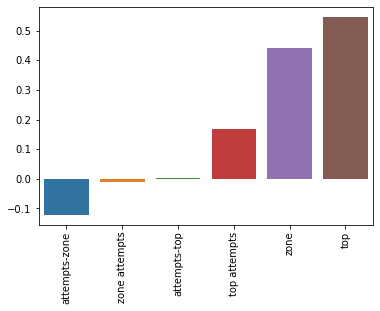

In [38]:
sns.barplot(x=df_engineered.corr()['Pass Qual'].sort_values().iloc[:-1].index,
            y=df_engineered.corr()['Pass Qual'].sort_values().iloc[:-1].values)
plt.xticks(rotation=90);

## Feature Engineering Conclusion
* About 2% of entriees were removed
* Attempt - score: (top) no significance (zone) negatively correlated

# Model Selection

Throughout the feature engineering, I figured out the top and zone socres are somewhat linearly correlated to passing qual. My intuition says linear logistic regression would work fine. Let's make logistic, tree-based, and SVM based classification models and evalueate them.

## Logistic Regression

In [39]:
from sklearn.model_selection import train_test_split
X = df_engineered.drop('Pass Qual',axis=1)
y = df_engineered['Pass Qual']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

#### Import Libraries

In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [42]:
scaler=StandardScaler()
log_model=LogisticRegression(penalty='elasticnet', solver='saga', max_iter=3000, class_weight='balanced')
# saga is the only solver available for elasticnet
# Default max_iter: 100, seems a bit small

In [43]:
# Construct Pipeline: Standard scale and logistic model with elastic net regularization
operations_logistic = [('scaler',scaler),('log_model',log_model)]
pipe_logistic = Pipeline(operations_logistic)

#### Let's start with logistic regression with elasticnet regularization 

In [44]:
param_grid = {'log_model__C':np.logspace(-2,2,20),'log_model__l1_ratio':np.linspace(0,1,20)}
cv_logistic = GridSearchCV(pipe_logistic, param_grid=param_grid, cv=5, scoring='accuracy')

In [45]:
cv_logistic.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('log_model',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=3000,
                                                           penalty='elasticnet',
                                                           solver='saga'))]),
             param_grid={'log_model__C': array([1.00000000e-02, 1.62377674e-02, 2.63665090e-02, 4.28133240e-02,
       6.95192796e-02, 1.12883789e-01, 1.83298071e-01, 2.97635144e-01,
       4.83293024e-01,...
       3.35981829e+00, 5.45559478e+00, 8.85866790e+00, 1.43844989e+01,
       2.33572147e+01, 3.79269019e+01, 6.15848211e+01, 1.00000000e+02]),
                         'log_model__l1_ratio': array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       

In [46]:
cv_logistic.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('log_model',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    l1_ratio=0.05263157894736842, max_iter=3000,
                                    penalty='elasticnet', solver='saga'))])

### Evaluate the logistic regression model

In [47]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [48]:
y_pred_logistic = cv_logistic.predict(X_test)

              precision    recall  f1-score   support

           0       0.78      0.82      0.80       118
           1       0.79      0.74      0.76       106

    accuracy                           0.78       224
   macro avg       0.78      0.78      0.78       224
weighted avg       0.78      0.78      0.78       224



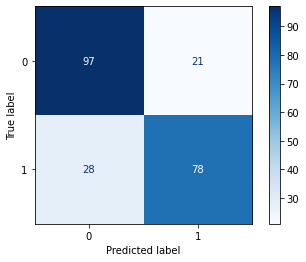

In [49]:
print(classification_report(y_test,y_pred_logistic))
ConfusionMatrixDisplay.from_estimator(cv_logistic,X_test,y_test,cmap='Blues')

### Good at predicting "Not Passing Qual" but not good at predicting "Passing Qual"
#### What does this mean regarding the model performance?

The dataset is a bit imbalanced: There are a lot more Failed cases than the Passing cases. The model is trained with accuracy and prediction can be biased (or weighted) toward "a player will not pass the Qual".

## Random Forest model
Random Forest model because

1. No need to worry about overfitting

2. Generally better performance than single tree method

In [50]:
from sklearn.ensemble import RandomForestClassifier

In [51]:
rfc = RandomForestClassifier(class_weight='balanced')

We don't need to scale the features because Tree based method only use one feature in a node.

In [52]:
rfc.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced')

In [53]:
y_pred_forest = rfc.predict(X_test)

In [54]:
print(X_train.columns)
print(rfc.feature_importances_)

Index(['top', 'zone', 'top attempts', 'zone attempts', 'attempts-top',
       'attempts-zone'],
      dtype='object')
[0.27189448 0.15642214 0.14272411 0.14481955 0.14050572 0.143634  ]


The forest model evaluate the importance: Top > Top Attempts > Zone Attempts > Zone: This is quite counter-intuitive!

### Evaluate the Forest Model
The forest model is worse in predicting both Passing Qual and Failing Qual than the logistic regression model. Let's try SVM-Classifier.

              precision    recall  f1-score   support

           0       0.73      0.72      0.73       118
           1       0.69      0.71      0.70       106

    accuracy                           0.71       224
   macro avg       0.71      0.71      0.71       224
weighted avg       0.71      0.71      0.71       224



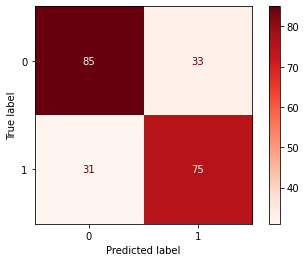

In [55]:
print(classification_report(y_test,y_pred_forest))
ConfusionMatrixDisplay.from_estimator(rfc,X_test,y_test,cmap='Reds')

## Support Vector Machine based model: SVC

In [56]:
from sklearn.svm import SVC

In [57]:
svc=SVC(class_weight='balanced') # Gridsearch 'C', 'gamma'
operation_svc = [('scaler',scaler),('svc',svc)]
pipe_svc = Pipeline(operation_svc)


param_grid={'svc__C':np.logspace(-2,2,20),'svc__gamma':['scale','auto']}
grid_svc = GridSearchCV(pipe_svc, param_grid, scoring='accuracy')

In [58]:
grid_svc.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svc', SVC(class_weight='balanced'))]),
             param_grid={'svc__C': array([1.00000000e-02, 1.62377674e-02, 2.63665090e-02, 4.28133240e-02,
       6.95192796e-02, 1.12883789e-01, 1.83298071e-01, 2.97635144e-01,
       4.83293024e-01, 7.84759970e-01, 1.27427499e+00, 2.06913808e+00,
       3.35981829e+00, 5.45559478e+00, 8.85866790e+00, 1.43844989e+01,
       2.33572147e+01, 3.79269019e+01, 6.15848211e+01, 1.00000000e+02]),
                         'svc__gamma': ['scale', 'auto']},
             scoring='accuracy')

In [59]:
grid_svc.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('svc', SVC(C=0.11288378916846889, class_weight='balanced'))])

In [60]:
grid_svc.best_params_

{'svc__C': 0.11288378916846889, 'svc__gamma': 'scale'}

              precision    recall  f1-score   support

           0       0.76      0.83      0.79       118
           1       0.79      0.71      0.75       106

    accuracy                           0.77       224
   macro avg       0.77      0.77      0.77       224
weighted avg       0.77      0.77      0.77       224



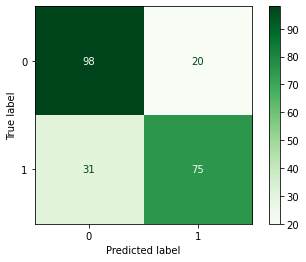

In [61]:
y_pred_svc = grid_svc.predict(X_test)
print(classification_report(y_test,y_pred_svc))
ConfusionMatrixDisplay.from_estimator(grid_svc,X_test,y_test,cmap='Greens')

# Model Evaluation and Selection

Logistic Regression Model
              precision    recall  f1-score   support

           0       0.78      0.82      0.80       118
           1       0.79      0.74      0.76       106

    accuracy                           0.78       224
   macro avg       0.78      0.78      0.78       224
weighted avg       0.78      0.78      0.78       224


Random Forest Model
              precision    recall  f1-score   support

           0       0.73      0.72      0.73       118
           1       0.69      0.71      0.70       106

    accuracy                           0.71       224
   macro avg       0.71      0.71      0.71       224
weighted avg       0.71      0.71      0.71       224


Support Vector Classifier Model
              precision    recall  f1-score   support

           0       0.76      0.83      0.79       118
           1       0.79      0.71      0.75       106

    accuracy                           0.77       224
   macro avg       0.77      0.77      0.77     

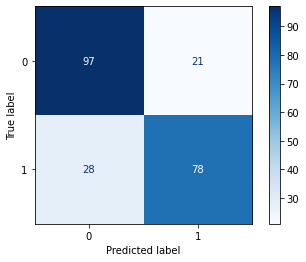

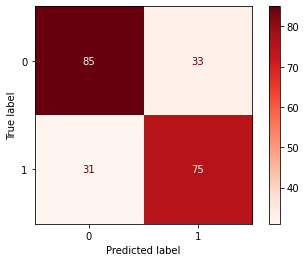

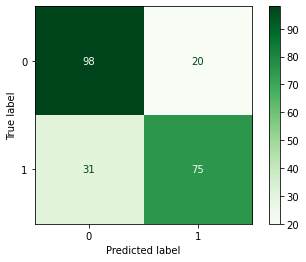

In [62]:
print("Logistic Regression Model")
print(classification_report(y_test,y_pred_logistic))
ConfusionMatrixDisplay.from_estimator(cv_logistic,X_test,y_test,cmap='Blues')
print('\nRandom Forest Model')
print(classification_report(y_test,y_pred_forest))
ConfusionMatrixDisplay.from_estimator(rfc,X_test,y_test,cmap='Reds')
print('\nSupport Vector Classifier Model')
print(classification_report(y_test,y_pred_svc))
ConfusionMatrixDisplay.from_estimator(grid_svc,X_test,y_test,cmap='Greens')

In [91]:
# Logistic Regression Feature Importance
print(cv_logistic.best_estimator_.named_steps.log_model.coef_.shape);
print(X.columns.shape);
logistic = pd.DataFrame(data= cv_logistic.best_estimator_.named_steps.log_model.coef_.reshape(-1,), index=X.columns, columns=['Importance']);
logistic.sort_values(by='Importance',ascending=False)

(1, 6)
(6,)


,Importance
top,0.695939
zone,0.413409
top attempts,0.045850
zone attempts,0.000000
attempts-zone,-0.068389
attempts-top,-0.087810


In [90]:
randomforest = pd.DataFrame(data=rfc.feature_importances_.reshape(-1,), index=X.columns, columns=['Importance'])
randomforest.sort_values(by='Importance', ascending=False)

,Importance
top,0.271894
zone,0.156422
zone attempts,0.144820
attempts-zone,0.143634
top attempts,0.142724
attempts-top,0.140506


In [93]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(grid_svc, X_test, y_test)
perm_importance.importances_mean
supportvector = pd.DataFrame(data=perm_importance.importances_mean.reshape(-1,), index=X.columns, columns=['Importance'])
supportvector.sort_values(by='Importance', ascending=False)

,Importance
top,0.163393
zone,0.050893
zone attempts,0.016071
attempts-zone,0.009821
attempts-top,0.002679
top attempts,-0.028571


# Conclusion
* Logistic Regression model performed marginally better than Support Vector Classifier and Random Forest. It will predict the results with ~ 80% accuracy.
* The "top", "zone" are the most two stongest features to predict the Qualification results. Top attempts - Top and Zone attempts - Zone are more relavant features than just "attempts"